In [1]:
print("hello world")

hello world


About the swin architecture:
- https://docs.pytorch.org/vision/main/models/swin_transformer.html 
- https://medium.com/@ovularslan/swin-transformer-in-depth-architecture-and-pytorch-implementation-a11e44d65aef



In [9]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torchvision import transforms # .v2 as transforms
from torchvision.models import swin_t
from torchvision.ops import sigmoid_focal_loss
from torch.amp import GradScaler

# Local imports
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
# print(parent_dir)
tool_path = os.path.abspath(os.path.normpath(parent_dir))
if tool_path not in sys.path:
    sys.path.insert(0, tool_path)

from tools.data_tools import crop_image_tensor
from tools.model_tools import validate, train_and_test_model
from tools.visualization_tools import plot_training_statistics, print_training_statistics
from classes.RetinaDataset import RetinaDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Data Transformation & Augmentation

In [3]:
mean, std = pd.read_csv(os.path.join(parent_dir, 'data', 'mean-std', 'mean_std_256_256.csv'))['Mean'].values, pd.read_csv(os.path.join(parent_dir, 'data', 'mean-std', 'mean_std_256_256.csv'))['Std'].values

mean = np.array(mean, dtype=np.float32, copy=True)
std = np.array(std, dtype=np.float32, copy=True)

mean_tensor = torch.from_numpy(mean)
std_tensor = torch.from_numpy(std)

print(f"Mean: {mean_tensor}")
print(f"Std: {std_tensor}")

Mean: tensor([0.4493, 0.2722, 0.1405])
Std: tensor([0.2548, 0.1612, 0.0879])


ResNet50 gets 256*256 tensors

In [4]:
# Appliquer les transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((256, 256)), 
    transforms.Normalize(mean=mean, std=std)
])

# Single augmentation transform with random applications
transform_augmented = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((256, 256)),
    transforms.RandomApply([
        transforms.RandomHorizontalFlip(p=1.0)
    ], p=0.5),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=15)  # Reduced from 30 to preserve medical image integrity
    ], p=0.3),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    ], p=0.3),
    transforms.Normalize(mean=mean, std=std)
])

## 2. Data Loading

In [5]:
train_dataset = RetinaDataset(
    root_dir='../../data/Training-Set/Training',
    csv_file='../../data/Training-Set/Training_Labels.csv',
    transform=transform_augmented,  # Use augmented transform with random applications
    type_of_classification='multilabel',
    label_for_multilabel_classification=["DR", "MH", "ODC"],
    add_normal_label=True
)

test_dataset = RetinaDataset(
    root_dir='../../data/Test-Set/Test',
    csv_file='../../data/Test-Set/Testing_Labels.csv',
    transform=transform,
    type_of_classification='multilabel',
    label_for_multilabel_classification=["DR", "MH", "ODC"],
    add_normal_label=True
)

val_dataset = RetinaDataset(
    root_dir='../../data/Evaluation-Set/Validation',
    csv_file='../../data/Evaluation-Set/Validation_Labels.csv',
    transform=transform,
    type_of_classification='multilabel',
    label_for_multilabel_classification=["DR", "MH", "ODC"],
    add_normal_label=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=5,
    pin_memory=True,
    persistent_workers=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=5,
    pin_memory=True,
    persistent_workers=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=5,
    pin_memory=True,
    persistent_workers=True
)

## 3. Swin definition

In [8]:
NUMBER_OF_LABELS = 4

model = swin_t(weights='DEFAULT') 
model.head = nn.Linear(model.head.in_features, NUMBER_OF_LABELS) 
model = model.to(device) 

for param in model.parameters(): # first layers frozen
    param.requires_grad = False
for param in model.head.parameters(): # last layer trainable
    param.requires_grad = True

## 4. Loss definition

In [10]:
alpha = 0.25  # penalisation of minor classes
gamma = 2.0   # focusing parameter for modulating factor (1-p) to reduce the relative loss for well-classified examples, putting more focus on hard, misclassified examples
criterion = lambda outputs, labels: sigmoid_focal_loss(
    outputs, labels, alpha=alpha, gamma=gamma, reduction='mean'
) # equivalent to nn.BCEWithLogitsLoss() when alpha=1 and gamma=0

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
scaler = GradScaler()  # For Automatic Mixed Precision

## 5. Model training

In [11]:
# Early stopping
patience = 5  
min_delta = 0.001  
best_test_loss = float('inf')
counter = 0

training_statistics = {
    'epoch': [],
    'train_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'test_accuracies': [],
    'test_f1s': [],
    'train_f1s': [],
    'train_roc_aucs': [],
    'test_roc_aucs': []
}

num_epochs = 30

In [12]:
for epoch in range(num_epochs):
    print(f"Epoch number: {epoch}")

    # Training and evaluation
    train_loss, train_accuracy, train_f1, train_roc_auc, test_loss, test_accuracy, test_f1, test_roc_auc = train_and_test_model(
        model=model, 
        train_loader=train_loader,
        test_loader=test_loader,
        optimizer=optimizer, 
        criterion=criterion, 
        device=device,
        num_labels=NUMBER_OF_LABELS,
        scaler=scaler)
    
    # Print metrics
    print_training_statistics(
        train_loss, train_accuracy, train_f1, train_roc_auc, 
        test_loss, test_accuracy, test_f1, test_roc_auc
    )
    
    scheduler.step(test_loss) 
    
    # Early stopping 
    if epoch > 15:
        if (best_test_loss - test_loss) > min_delta:
            best_test_loss = test_loss
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print(f"Early stopping à l'epoch {epoch}")
            break

    # Metrics storage
    training_statistics['epoch'].append(epoch)
    training_statistics['train_losses'].append(train_loss)
    training_statistics['train_accuracies'].append(train_accuracy)
    training_statistics['train_f1s'].append(train_f1)
    training_statistics['train_roc_aucs'].append(train_roc_auc)
    training_statistics['test_losses'].append(test_loss)
    training_statistics['test_accuracies'].append(test_accuracy)
    training_statistics['test_f1s'].append(test_f1)
    training_statistics['test_roc_aucs'].append(test_roc_auc)



Epoch number: 0


100%|██████████| 10/10 [00:29<00:00,  2.91s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0698 | Train Accuracy: 0.6971 | Train F1-score: 0.1617 | Train ROC-AUC: 0.5593 |
| Test Loss:  0.0627 | Test Accuracy:  0.7238 | Test F1-score:  0.0000 | Test ROC-AUC:  0.7348 |
------------------------------------------------------------------------------------------------
Epoch number: 1


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0523 | Train Accuracy: 0.7396 | Train F1-score: 0.0778 | Train ROC-AUC: 0.7389 |
| Test Loss:  0.0462 | Test Accuracy:  0.7860 | Test F1-score:  0.3959 | Test ROC-AUC:  0.8178 |
------------------------------------------------------------------------------------------------
Epoch number: 2


100%|██████████| 10/10 [00:29<00:00,  2.96s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0446 | Train Accuracy: 0.7837 | Train F1-score: 0.3828 | Train ROC-AUC: 0.8291 |
| Test Loss:  0.0402 | Test Accuracy:  0.7896 | Test F1-score:  0.4103 | Test ROC-AUC:  0.8725 |
------------------------------------------------------------------------------------------------
Epoch number: 3


100%|██████████| 10/10 [00:31<00:00,  3.18s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0409 | Train Accuracy: 0.7831 | Train F1-score: 0.3607 | Train ROC-AUC: 0.8568 |
| Test Loss:  0.0391 | Test Accuracy:  0.7951 | Test F1-score:  0.4286 | Test ROC-AUC:  0.8882 |
------------------------------------------------------------------------------------------------
Epoch number: 4


100%|██████████| 10/10 [00:32<00:00,  3.23s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0394 | Train Accuracy: 0.7988 | Train F1-score: 0.4363 | Train ROC-AUC: 0.8664 |
| Test Loss:  0.0368 | Test Accuracy:  0.8195 | Test F1-score:  0.5389 | Test ROC-AUC:  0.8989 |
------------------------------------------------------------------------------------------------
Epoch number: 5


100%|██████████| 10/10 [00:31<00:00,  3.20s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0374 | Train Accuracy: 0.8094 | Train F1-score: 0.4769 | Train ROC-AUC: 0.8859 |
| Test Loss:  0.0352 | Test Accuracy:  0.8207 | Test F1-score:  0.5377 | Test ROC-AUC:  0.9108 |
------------------------------------------------------------------------------------------------
Epoch number: 6


100%|██████████| 10/10 [00:31<00:00,  3.19s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0362 | Train Accuracy: 0.8110 | Train F1-score: 0.4921 | Train ROC-AUC: 0.8965 |
| Test Loss:  0.0347 | Test Accuracy:  0.8268 | Test F1-score:  0.5644 | Test ROC-AUC:  0.9135 |
------------------------------------------------------------------------------------------------
Epoch number: 7


100%|██████████| 10/10 [00:31<00:00,  3.20s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0360 | Train Accuracy: 0.8194 | Train F1-score: 0.5216 | Train ROC-AUC: 0.8943 |
| Test Loss:  0.0340 | Test Accuracy:  0.8341 | Test F1-score:  0.5916 | Test ROC-AUC:  0.9170 |
------------------------------------------------------------------------------------------------
Epoch number: 8


100%|██████████| 10/10 [00:31<00:00,  3.13s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0349 | Train Accuracy: 0.8245 | Train F1-score: 0.5468 | Train ROC-AUC: 0.9024 |
| Test Loss:  0.0333 | Test Accuracy:  0.8360 | Test F1-score:  0.5979 | Test ROC-AUC:  0.9216 |
------------------------------------------------------------------------------------------------
Epoch number: 9


100%|██████████| 10/10 [00:31<00:00,  3.13s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0353 | Train Accuracy: 0.8220 | Train F1-score: 0.5339 | Train ROC-AUC: 0.9000 |
| Test Loss:  0.0329 | Test Accuracy:  0.8366 | Test F1-score:  0.6000 | Test ROC-AUC:  0.9217 |
------------------------------------------------------------------------------------------------
Epoch number: 10


100%|██████████| 10/10 [00:31<00:00,  3.13s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0338 | Train Accuracy: 0.8276 | Train F1-score: 0.5513 | Train ROC-AUC: 0.9118 |
| Test Loss:  0.0328 | Test Accuracy:  0.8409 | Test F1-score:  0.6156 | Test ROC-AUC:  0.9226 |
------------------------------------------------------------------------------------------------
Epoch number: 11


100%|██████████| 10/10 [00:32<00:00,  3.22s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0343 | Train Accuracy: 0.8296 | Train F1-score: 0.5635 | Train ROC-AUC: 0.9056 |
| Test Loss:  0.0326 | Test Accuracy:  0.8409 | Test F1-score:  0.6156 | Test ROC-AUC:  0.9240 |
------------------------------------------------------------------------------------------------
Epoch number: 12


100%|██████████| 10/10 [00:31<00:00,  3.14s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0328 | Train Accuracy: 0.8316 | Train F1-score: 0.5745 | Train ROC-AUC: 0.9176 |
| Test Loss:  0.0319 | Test Accuracy:  0.8451 | Test F1-score:  0.6308 | Test ROC-AUC:  0.9272 |
------------------------------------------------------------------------------------------------
Epoch number: 13


100%|██████████| 10/10 [00:31<00:00,  3.11s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0329 | Train Accuracy: 0.8331 | Train F1-score: 0.5743 | Train ROC-AUC: 0.9161 |
| Test Loss:  0.0321 | Test Accuracy:  0.8476 | Test F1-score:  0.6366 | Test ROC-AUC:  0.9262 |
------------------------------------------------------------------------------------------------
Epoch number: 14


100%|██████████| 10/10 [00:30<00:00,  3.06s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0322 | Train Accuracy: 0.8353 | Train F1-score: 0.5874 | Train ROC-AUC: 0.9203 |
| Test Loss:  0.0314 | Test Accuracy:  0.8476 | Test F1-score:  0.6366 | Test ROC-AUC:  0.9301 |
------------------------------------------------------------------------------------------------
Epoch number: 15


100%|██████████| 10/10 [00:32<00:00,  3.21s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0321 | Train Accuracy: 0.8404 | Train F1-score: 0.5990 | Train ROC-AUC: 0.9190 |
| Test Loss:  0.0313 | Test Accuracy:  0.8500 | Test F1-score:  0.6445 | Test ROC-AUC:  0.9307 |
------------------------------------------------------------------------------------------------
Epoch number: 16


100%|██████████| 10/10 [00:31<00:00,  3.17s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0322 | Train Accuracy: 0.8418 | Train F1-score: 0.6061 | Train ROC-AUC: 0.9203 |
| Test Loss:  0.0309 | Test Accuracy:  0.8530 | Test F1-score:  0.6572 | Test ROC-AUC:  0.9319 |
------------------------------------------------------------------------------------------------
Epoch number: 17


100%|██████████| 10/10 [00:33<00:00,  3.31s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0323 | Train Accuracy: 0.8390 | Train F1-score: 0.5989 | Train ROC-AUC: 0.9190 |
| Test Loss:  0.0309 | Test Accuracy:  0.8512 | Test F1-score:  0.6484 | Test ROC-AUC:  0.9328 |
------------------------------------------------------------------------------------------------
Epoch number: 18


100%|██████████| 10/10 [00:31<00:00,  3.16s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0316 | Train Accuracy: 0.8404 | Train F1-score: 0.6018 | Train ROC-AUC: 0.9231 |
| Test Loss:  0.0307 | Test Accuracy:  0.8543 | Test F1-score:  0.6581 | Test ROC-AUC:  0.9335 |
------------------------------------------------------------------------------------------------
Epoch number: 19


100%|██████████| 10/10 [00:31<00:00,  3.20s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0317 | Train Accuracy: 0.8431 | Train F1-score: 0.6132 | Train ROC-AUC: 0.9241 |
| Test Loss:  0.0304 | Test Accuracy:  0.8518 | Test F1-score:  0.6524 | Test ROC-AUC:  0.9350 |
------------------------------------------------------------------------------------------------
Epoch number: 20


100%|██████████| 10/10 [00:32<00:00,  3.23s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0312 | Train Accuracy: 0.8398 | Train F1-score: 0.6009 | Train ROC-AUC: 0.9249 |
| Test Loss:  0.0305 | Test Accuracy:  0.8530 | Test F1-score:  0.6552 | Test ROC-AUC:  0.9348 |
------------------------------------------------------------------------------------------------
Epoch number: 21


100%|██████████| 10/10 [00:30<00:00,  3.09s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.0313 | Train Accuracy: 0.8453 | Train F1-score: 0.6234 | Train ROC-AUC: 0.9247 |
| Test Loss:  0.0302 | Test Accuracy:  0.8543 | Test F1-score:  0.6571 | Test ROC-AUC:  0.9363 |
------------------------------------------------------------------------------------------------
Early stopping à l'epoch 21


In [13]:
torch.save(model.state_dict(), '../Models/model_ft_swin_t_mcmlc.pth')

In [14]:
training_statistics_df = pd.DataFrame(training_statistics)
training_statistics_df.to_csv('../Training-Statistics/ts_model_ft_swin_t_mcmlc.csv', index=False)

## 6. Evolution of the training

In [15]:
training_statistics_df = pd.read_csv('../Training-Statistics/ts_model_ft_swin_t_mcmlc.csv')

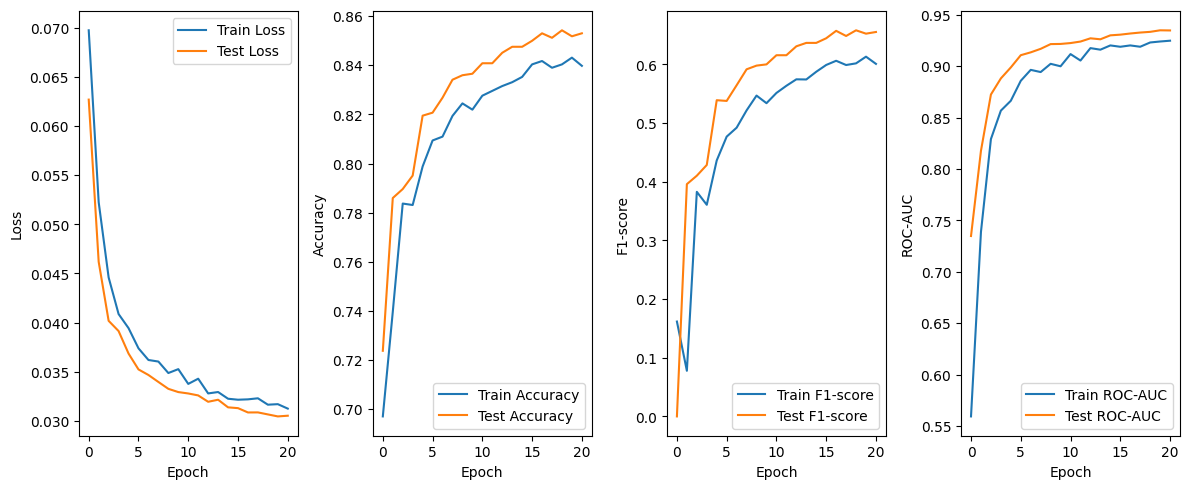

In [16]:
plot_training_statistics(
    training_statistics_df, 
    saving_path='../Training-Evolution-Images/te_model_ft_swin_t_mcmlc_zoomed.png',
    title='Training Evolution - Fine Tuned Swin Multi-Class Multi-Label Classification Zoomed',
    zoomed=True
)


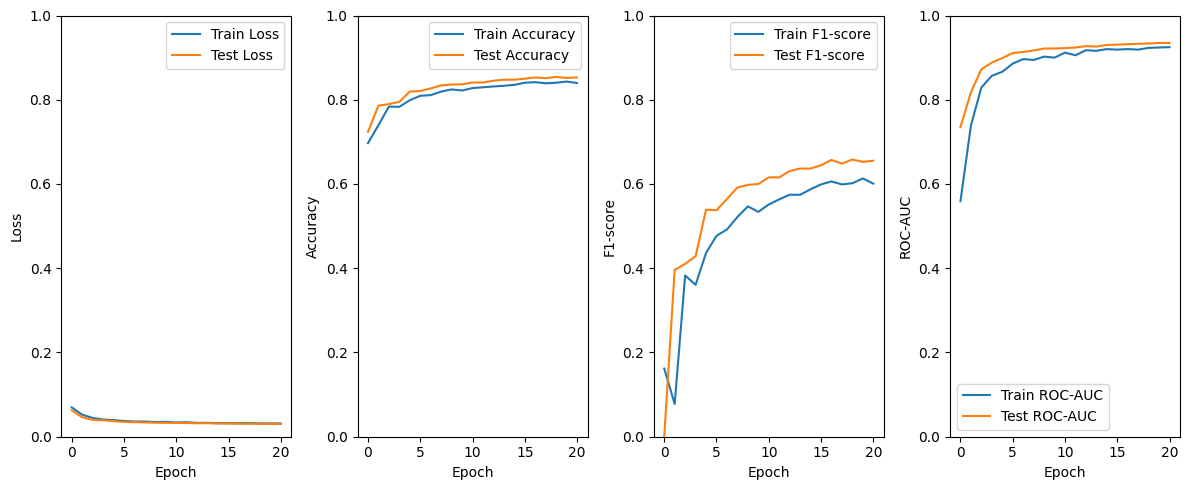

In [17]:
plot_training_statistics(
    training_statistics_df, 
    saving_path='../Training-Evolution-Images/te_model_ft_swin_t_mcmlc.png',
    title='Training Evolution - Fine Tuned Swin Multi-Class Multi-Label Classification',
    zoomed=False
)


## 7. Model evaluation

In [18]:
model = swin_t(weights="DEFAULT")
model.head = nn.Linear(model.head.in_features, NUMBER_OF_LABELS) 
model = model.to(device) 
model.load_state_dict(torch.load('../Models/model_ft_swin_t_mcmlc.pth', weights_only=True))

<All keys matched successfully>

In [19]:
val_loss, val_accuracy, val_f1, val_roc_auc = validate(model, val_loader, criterion, device=device, num_labels=NUMBER_OF_LABELS)

In [20]:
print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f} | Validation F1-score: {val_f1:.4f} | Validation ROC-AUC: {val_roc_auc:.4f}")

Validation Loss: 0.0251 | Validation Accuracy: 0.8579 | Validation F1-score: 0.6647 | Validation ROC-AUC: 0.9378
